# Data Exploration and Pre-processing

This notebook performs the following tasks for analyzing attack data.

1. **Dataset Preparation**
    - Install required libraries (`pyarrow`, `pandas`, `numpy`, `matplotlib`, `seaborn`).
    - Load the dataset (`ssh_attacks.parquet`) into a Pandas DataFrame.
    - Inspect the dataset schema: check for missing values, anomalies, or inconsistencies.
    
2. **Temporal Analysis**
    - Convert `first_timestamp` to a datetime format.
    - Analyze attack frequencies over time: hourly, daily, monthly trends.
    - Plot time-series graphs for attack distributions.
    - Extra frequency plot divided by classes.

3. **Session Analysis**
    - Analyze `full_session`:
        - Count characters per session and plot its distribution.
        - Count words per session and plot its distribution.
    - Extract the most common words using tokenization.
    - Create visualizations: bar plots for word frequencies and word clouds.

4. **Intent Distribution**
    - Explore the `Set_Fingerprint` column:
        - Count the occurrences of each intent.
        - Analyze the co-occurrence of intents per session.
        - Visualize with bar plots and co-occurrence heatmaps.
    - Analyze temporal trends for intents (e.g., intent frequency over time).

5. **Text Representation**
    - Convert `full_session` to numerical formats:
        - Implement Bag-of-Words (BoW).
        - Compute TF-IDF for each word and associate with sessions.
    - Store the preprocessed features for supervised learning.

6. **Error Reporting**
    - Document potential misclassified sessions and examples.

## Dataset Preparation

### text

In [2]:
!pip install pyarrow

  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)


In [3]:
!pip install wordcloud

  Using cached wordcloud-1.9.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
import re
from collections import Counter
from wordcloud import WordCloud  
import itertools

In [5]:
SSH_Attacks = pd.read_parquet("../data/raw/ssh_attacks.parquet")

In [6]:
SSH_Attacks

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


### text

In [7]:
import pandas as pd
import numpy as np

# Assuming SSH_Attacks is your DataFrame
# Example: SSH_Attacks = pd.read_csv('path_to_ssh_attacks_data.csv')

# 1. Inspect the basic structure (columns and data types)
print("Dataset Structure:")
print(SSH_Attacks.info())

# 2. Check for missing values
print("\nMissing Values:")
print(SSH_Attacks.isnull().sum())  # Display the number of missing values per column

# 3. Check for duplicates
print("\nDuplicate Rows:")
# Handle unhashable types in columns (e.g., lists or arrays)
# Convert columns that might be unhashable into a hashable format before checking for duplicates
# We will convert columns with object types that are not lists or arrays to string (if needed).
# print(SSH_Attacks['Set_Fingerprint'].value_counts())

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233035 entries, 0 to 233034
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   session_id       233035 non-null  int64 
 1   full_session     233035 non-null  object
 2   first_timestamp  233035 non-null  object
 3   Set_Fingerprint  233035 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.1+ MB
None

Missing Values:
session_id         0
full_session       0
first_timestamp    0
Set_Fingerprint    0
dtype: int64

Duplicate Rows:


In [8]:
# If the column already contains lists, apply explode directly
all_classes = SSH_Attacks['Set_Fingerprint'].explode().str.strip()

# Now, count the occurrences of each class
class_counts = all_classes.value_counts()

print(class_counts)

Discovery          232145
Persistence        211295
Execution           92927
Defense Evasion     18999
Harmless             2206
Other                 327
Impact                 27
Name: Set_Fingerprint, dtype: int64


### text

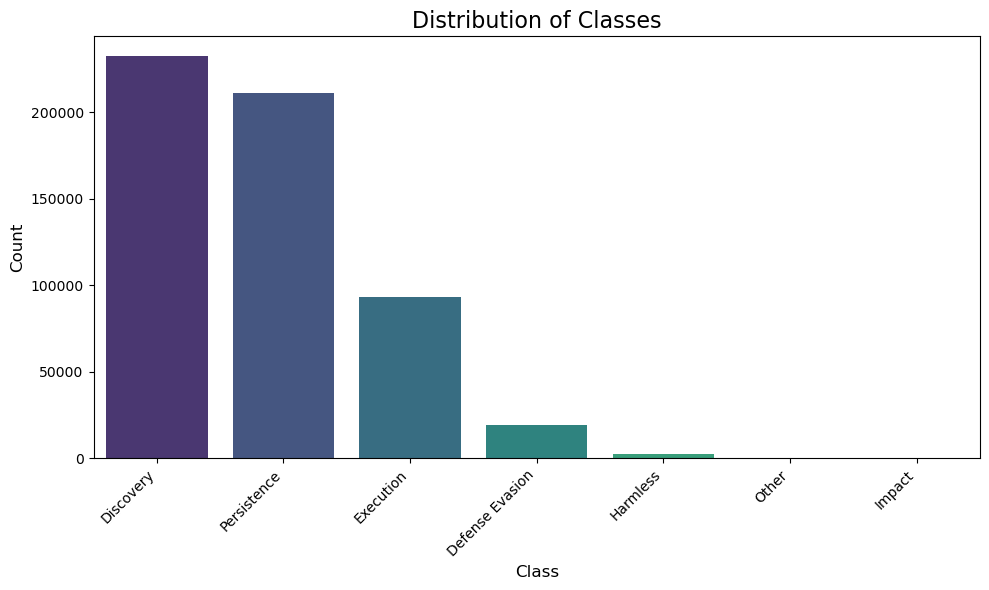

In [9]:
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

# Temporal Analysis

### text

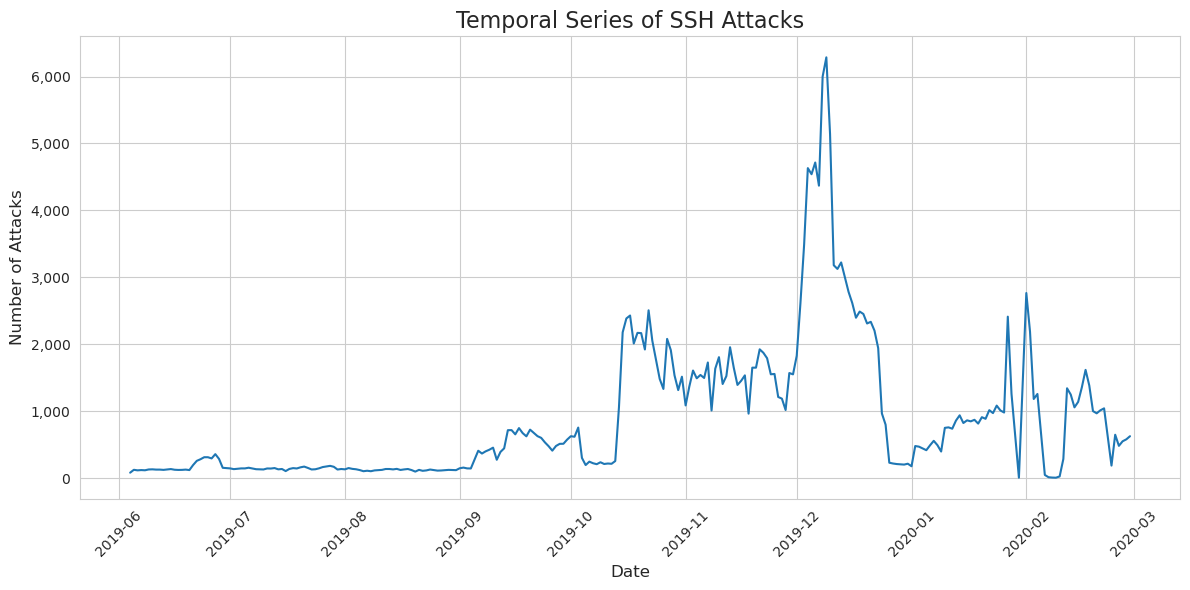

In [10]:
# Ensure the first_timestamp column is in datetime format
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])

# Aggregate data by date
temporal_series = (
    SSH_Attacks.groupby(SSH_Attacks['first_timestamp'].dt.date)
    .size()
    .reset_index(name='attack_count')
)

# Rename columns for clarity
temporal_series.rename(columns={'first_timestamp': 'date'}, inplace=True)

# Define a formatter for the y-axis
def thousands_formatter(x, _):
    return f"{int(x):,}"

# Plot the data
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=temporal_series, x='date', y='attack_count')

# Improve x and y-axis formatting
plt.title('Temporal Series of SSH Attacks', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Add tight layout for better spacing
plt.tight_layout()
plt.show()

### text

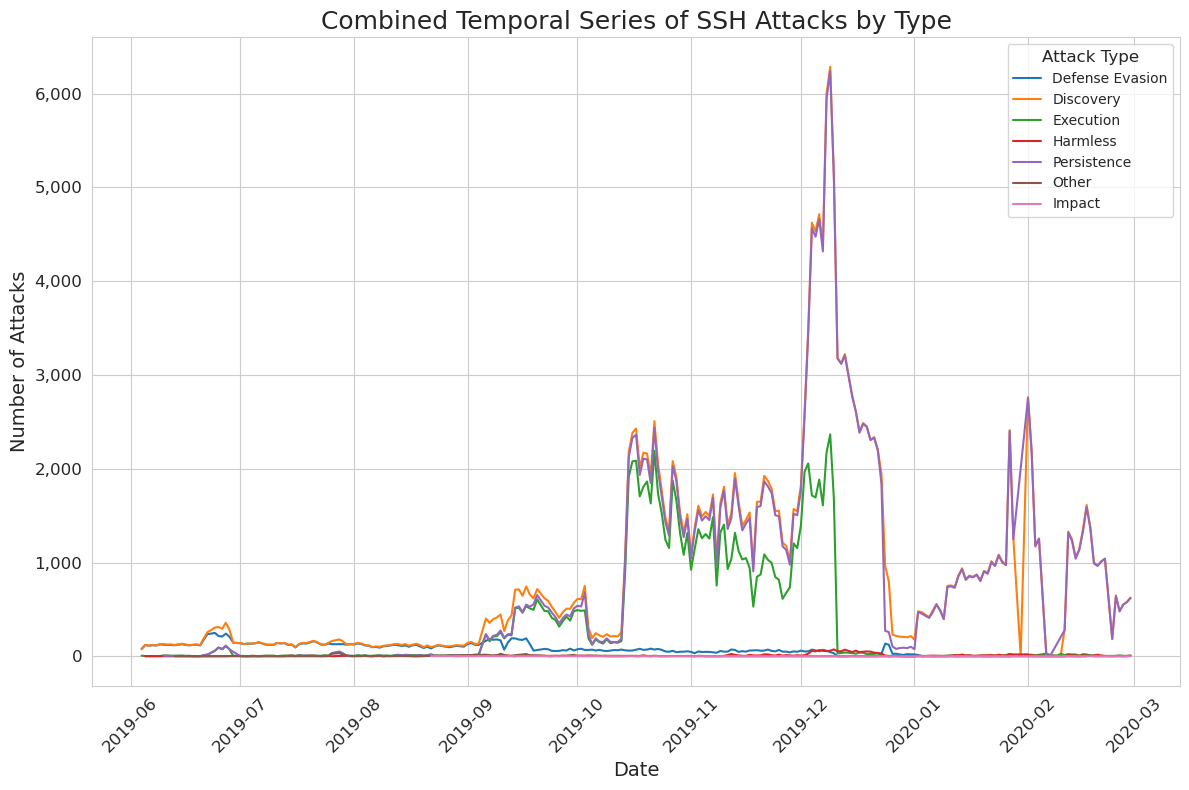

In [11]:
# Ensure the first_timestamp column is in datetime format
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])

# Explode the Set_Fingerprint column to create separate rows for each intent
SSH_Attacks_exploded = SSH_Attacks.explode('Set_Fingerprint')

# Group by Set_Fingerprint and date to count occurrences
grouped_SSH_Attacks = (
    SSH_Attacks_exploded.groupby([SSH_Attacks_exploded['first_timestamp'].dt.date, 'Set_Fingerprint'])
    .size()
    .reset_index(name='attack_count')
)

# Rename columns for clarity
grouped_SSH_Attacks.rename(columns={'first_timestamp': 'date'}, inplace=True)

# Plot a final graph that includes all the attack types
plt.figure(figsize=(12, 8))
unique_fingerprints = grouped_SSH_Attacks['Set_Fingerprint'].unique()
for fingerprint in unique_fingerprints:
    temp_SSH_Attacks = grouped_SSH_Attacks[grouped_SSH_Attacks['Set_Fingerprint'] == fingerprint]
    sns.lineplot(data=temp_SSH_Attacks, x='date', y='attack_count', label=fingerprint)

# Improve x and y-axis formatting
plt.title('Combined Temporal Series of SSH Attacks by Type', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Attacks', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.legend(title='Attack Type', fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.show()

### text

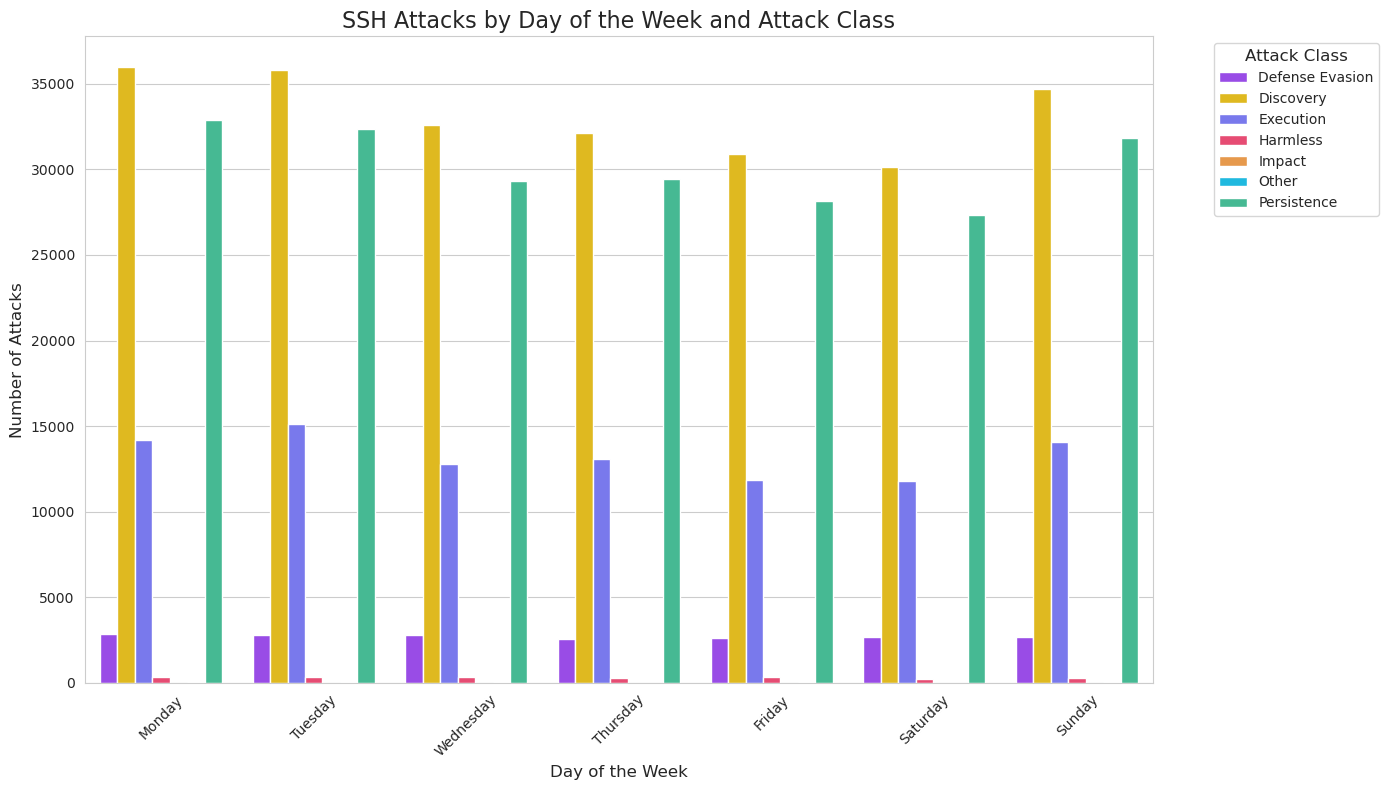

In [12]:
# Ensure the first_timestamp column is in datetime format (if not already)
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])
# Extract the day of the week from the first_timestamp column
SSH_Attacks['day_of_week'] = SSH_Attacks['first_timestamp'].dt.day_name()
# Explode the Set_Fingerprint column to create separate rows for each intent
SSH_Attacks_exploded = SSH_Attacks.explode('Set_Fingerprint')
# Group by day_of_week and Set_Fingerprint, and count the unique occurrences of first_timestamp
attack_counts_by_day_fingerprint = (
    SSH_Attacks_exploded.groupby(['day_of_week', 'Set_Fingerprint'])
    .agg(attack_count=('first_timestamp', 'nunique'))
    .reset_index()
)
# Ensure the days of the week are ordered correctly
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
attack_counts_by_day_fingerprint['day_of_week'] = pd.Categorical(attack_counts_by_day_fingerprint['day_of_week'], categories=ordered_days, ordered=True)
attack_counts_by_day_fingerprint = attack_counts_by_day_fingerprint.sort_values(['day_of_week', 'Set_Fingerprint'])

custom_palette = ['#9933FF','#FFCC00',  '#6666FF', '#FF3366', '#FF9933', '#00CCFF', '#33CC99']


# Plot the histogram with the new color palette
plt.figure(figsize=(14, 8))
sns.barplot(data=attack_counts_by_day_fingerprint, 
            x='day_of_week', 
            y='attack_count', 
            hue='Set_Fingerprint', 
            palette=custom_palette)

# Improve plot aesthetics
plt.title('SSH Attacks by Day of the Week and Attack Class', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Attack Class', fontsize=10, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### text

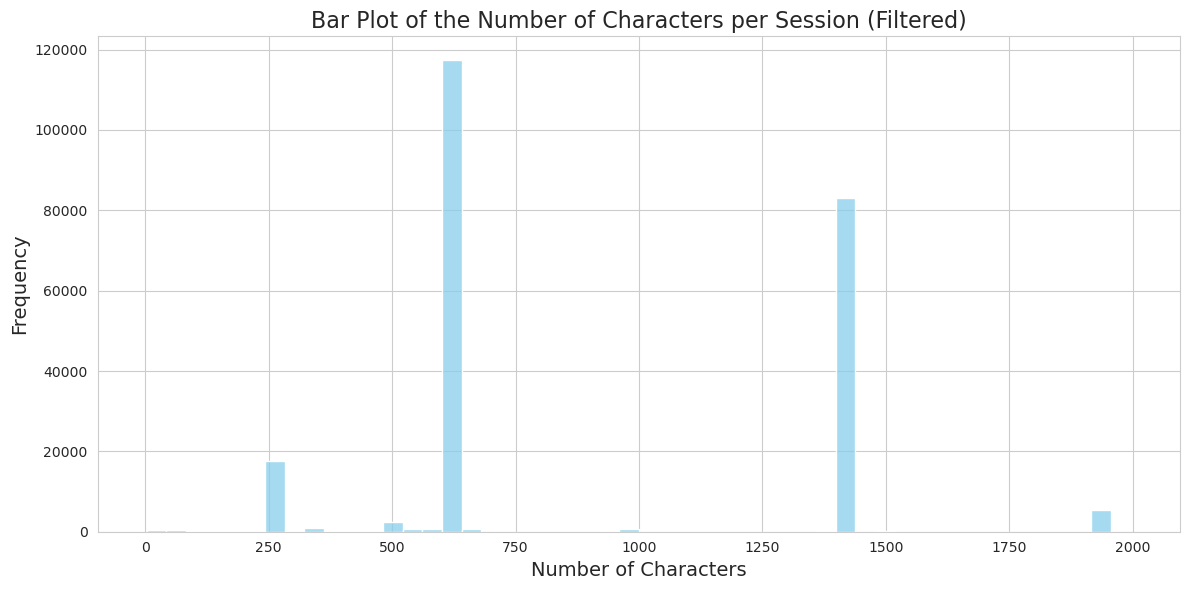

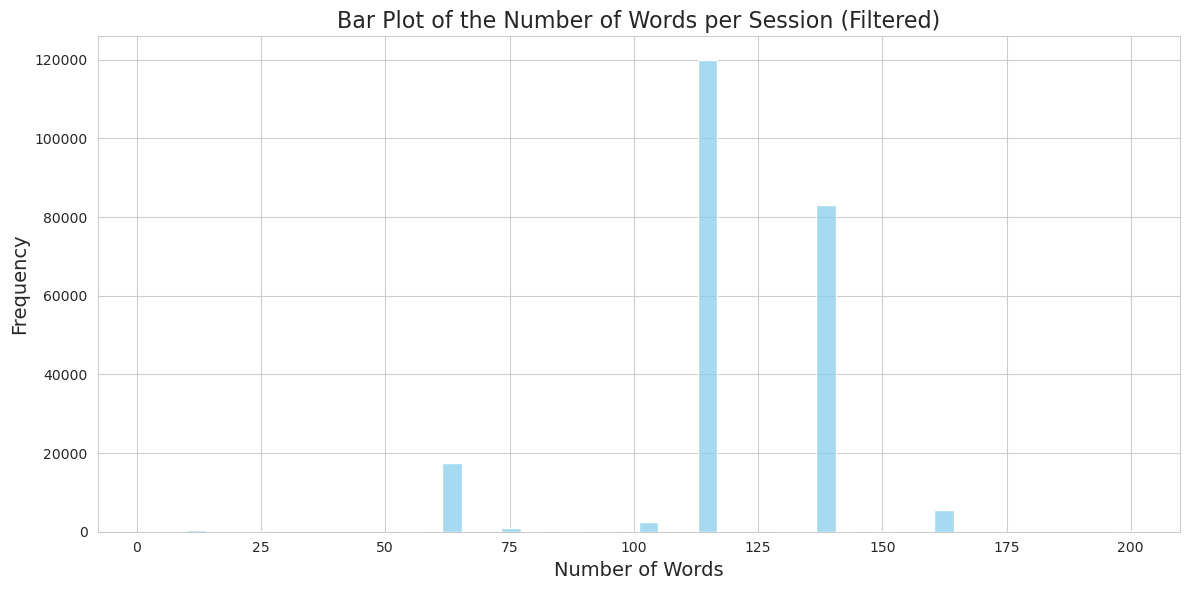

In [13]:
# Extract features
SSH_Attacks['num_characters'] = SSH_Attacks['full_session'].apply(len)
SSH_Attacks['num_words'] = SSH_Attacks['full_session'].apply(lambda x: len(x.split()))

# Define a threshold for filtering out sessions with extremely high character or word counts
character_threshold = 2000  # Limit the number of characters to 2000
word_threshold = 200  # Limit the number of words to 200

# Filter out outliers based on thresholds
filtered_data_characters = SSH_Attacks[SSH_Attacks['num_characters'] <= character_threshold]
filtered_data_words = SSH_Attacks[SSH_Attacks['num_words'] <= word_threshold]

# Plot the bar plot for the distribution of the number of characters per session (filtered)
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data_characters['num_characters'], kde=False, bins=50, color='skyblue')
plt.title('Bar Plot of the Number of Characters per Session (Filtered)', fontsize=16)
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

# Plot the bar plot for the distribution of the number of words per session (filtered)
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data_words['num_words'], kde=False, bins=50, color='skyblue')
plt.title('Bar Plot of the Number of Words per Session (Filtered)', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

# Intent Distribution

### text

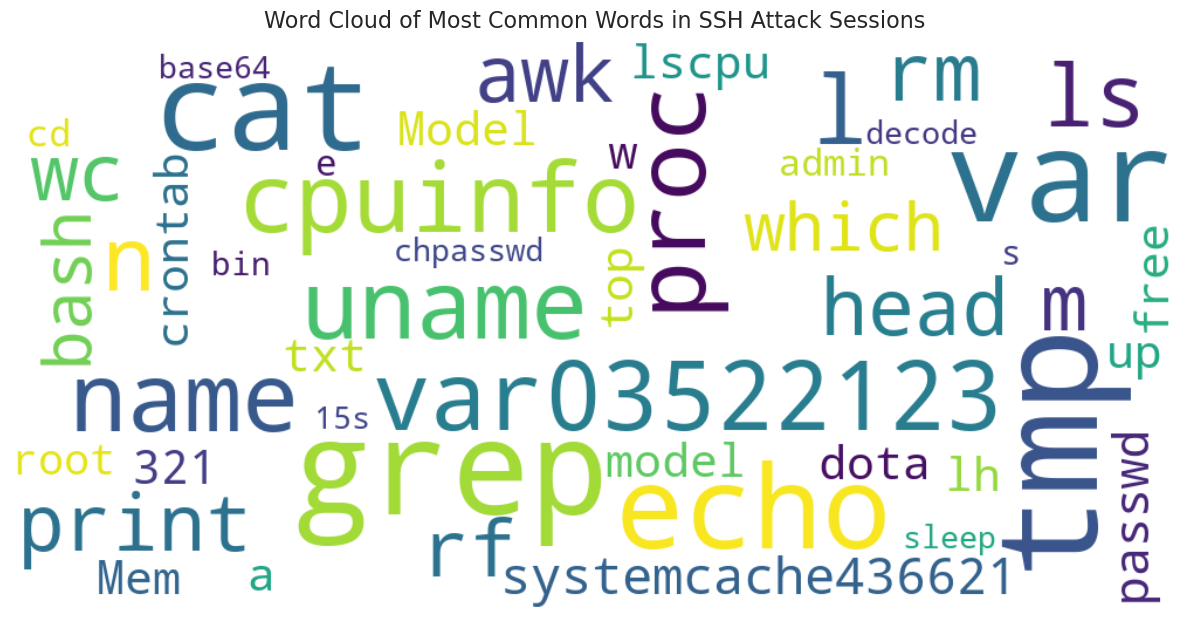

In [14]:
# Extract the full_session column and split all text into words, ignoring special characters
all_words = SSH_Attacks['full_session'].str.cat(sep=' ')

# Regular expression to capture words while excluding special characters, words starting with '-', and single numbers
all_words_cleaned = re.findall(r'\b(?!-)\w+\b', all_words)  # Capture words, ignoring '-' at the start

# Remove specific special characters like ';' and '|', and exclude single numbers
all_words_cleaned = [word for word in all_words_cleaned if not (word.isdigit() and len(word) == 1)]
all_words_cleaned = [word for word in all_words_cleaned if ';' not in word and '|' not in word]

# Count the occurrences of each word
word_counts = Counter(all_words_cleaned)

# Generate a word cloud visualization with reduced word size
wordcloud = WordCloud(
    width=1000, 
    height=500, 
    max_font_size=120,   # Reduce max font size to make the word sizes smaller
    min_font_size=20,   # Add min font size for smaller words
    background_color='white'
).generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in SSH Attack Sessions', fontsize=16)
plt.tight_layout()
plt.show()

# Intents distribution

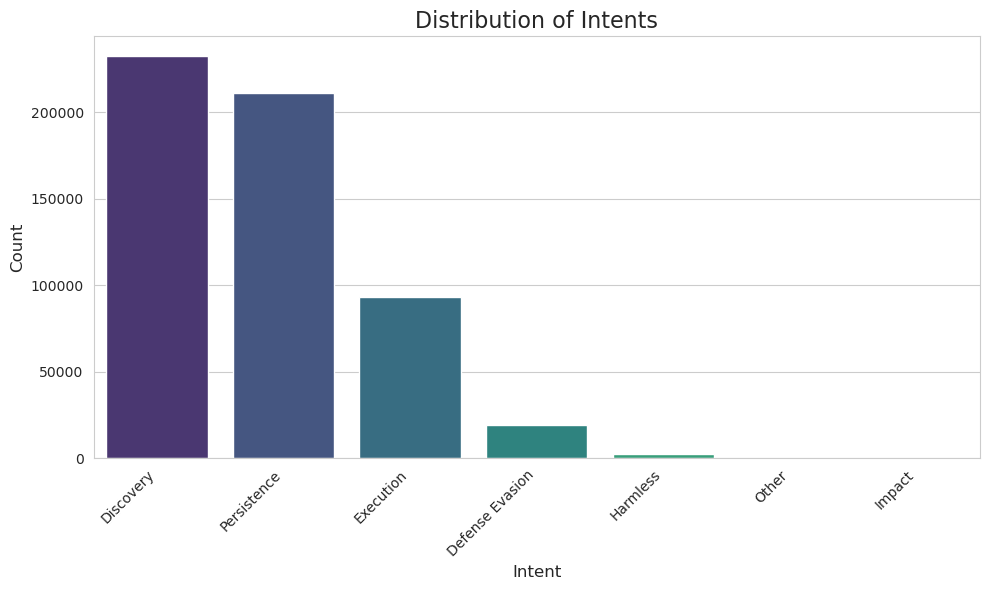

In [15]:
# Count occurrences of each intent
intent_counts = SSH_Attacks['Set_Fingerprint'].explode().value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=intent_counts.index, y=intent_counts.values, palette='viridis')
plt.title('Distribution of Intents', fontsize=16)
plt.xlabel('Intent', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze the co-occurrence of intents per session.

First few rows of Set_Fingerprint column:
0    [Defense Evasion, Discovery]
1    [Defense Evasion, Discovery]
2    [Defense Evasion, Discovery]
3    [Defense Evasion, Discovery]
4    [Defense Evasion, Discovery]
5    [Defense Evasion, Discovery]
6    [Defense Evasion, Discovery]
7    [Defense Evasion, Discovery]
8    [Defense Evasion, Discovery]
9    [Defense Evasion, Discovery]
Name: Set_Fingerprint, dtype: object

Data types of the Set_Fingerprint entries:
[<class 'numpy.ndarray'>]

First few parsed intents lists after extraction:
0    [Defense Evasion, Discovery]
1    [Defense Evasion, Discovery]
2    [Defense Evasion, Discovery]
3    [Defense Evasion, Discovery]
4    [Defense Evasion, Discovery]
5    [Defense Evasion, Discovery]
6    [Defense Evasion, Discovery]
7    [Defense Evasion, Discovery]
8    [Defense Evasion, Discovery]
9    [Defense Evasion, Discovery]
Name: Set_Fingerprint, dtype: object

Mapping of intents to rows after parsing:
Intent: Defense Evasion, Rows: 18999
Inte

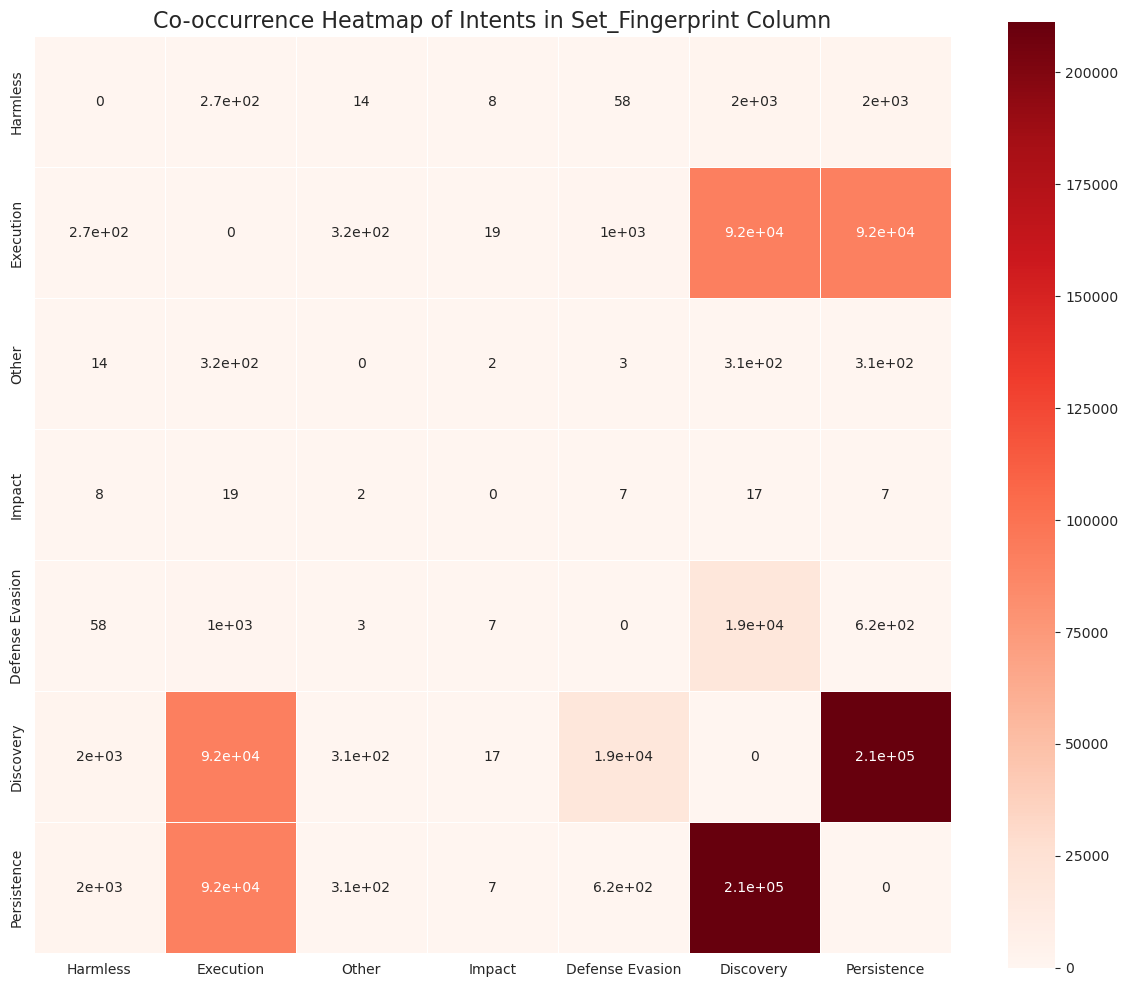

In [16]:
# Print the first few rows of Set_Fingerprint to analyze the raw content
print("First few rows of Set_Fingerprint column:")
print(SSH_Attacks['Set_Fingerprint'].head(10))


print("\nData types of the Set_Fingerprint entries:")
print(SSH_Attacks['Set_Fingerprint'].apply(type).unique())

# Extract the Set_Fingerprint column and ensure it contains lists of intents
# Adjust the extraction logic based on observed data
def extract_intents(entry):
    if isinstance(entry, np.ndarray):
        return entry.tolist()  # Convert numpy array to list
    elif isinstance(entry, list):
        return entry
    else:
        return []

# Apply the extraction function to the Set_Fingerprint column
intents_list = SSH_Attacks['Set_Fingerprint'].apply(extract_intents)

print("\nFirst few parsed intents lists after extraction:")
print(intents_list.head(10))

# Create a dictionary to track the rows each intent appears in
intent_to_rows = {}

# Populate the dictionary
for idx, intents in enumerate(intents_list):
    if isinstance(intents, list) and len(intents) > 0:
        for intent in intents:
            if intent not in intent_to_rows:
                intent_to_rows[intent] = set()
            intent_to_rows[intent].add(idx)


print("\nMapping of intents to rows after parsing:")
for intent, rows in intent_to_rows.items():
    print(f"Intent: {intent}, Rows: {len(rows)}")

# Create a set of all unique intents
all_intents = set(intent_to_rows.keys())

# Create a DataFrame that tracks the co-occurrence of intents
co_occurrence_matrix = pd.DataFrame(0, index=all_intents, columns=all_intents)

# Update the co-occurrence matrix based on the rows each intent appears in
for intent1, rows1 in intent_to_rows.items():
    for intent2, rows2 in intent_to_rows.items():
        if intent1 != intent2:
            # Calculate the number of rows where both intents co-occur
            co_occurrence_count = len(rows1.intersection(rows2))
            co_occurrence_matrix.loc[intent1, intent2] = co_occurrence_count


print("\nCo-occurrence Matrix after processing intents:")
print(co_occurrence_matrix)

# Check if the matrix has any non-zero values
if (co_occurrence_matrix != 0).any().any():
    print("\nNon-zero values found in co-occurrence matrix, proceeding to plot.")
else:
    print("\nNo non-zero values found in co-occurrence matrix. Please check the data processing steps.")

# Plot the co-occurrence heatmap if there is data to visualize
if not co_occurrence_matrix.empty and (co_occurrence_matrix != 0).any().any():
    plt.figure(figsize=(12, 10))
    sns.heatmap(co_occurrence_matrix, annot=True, cmap='Reds', linewidths=0.5, square=True)
    plt.title('Co-occurrence Heatmap of Intents in Set_Fingerprint Column', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No co-occurrence data available to visualize.")

# Analyze temporal trends for intents

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


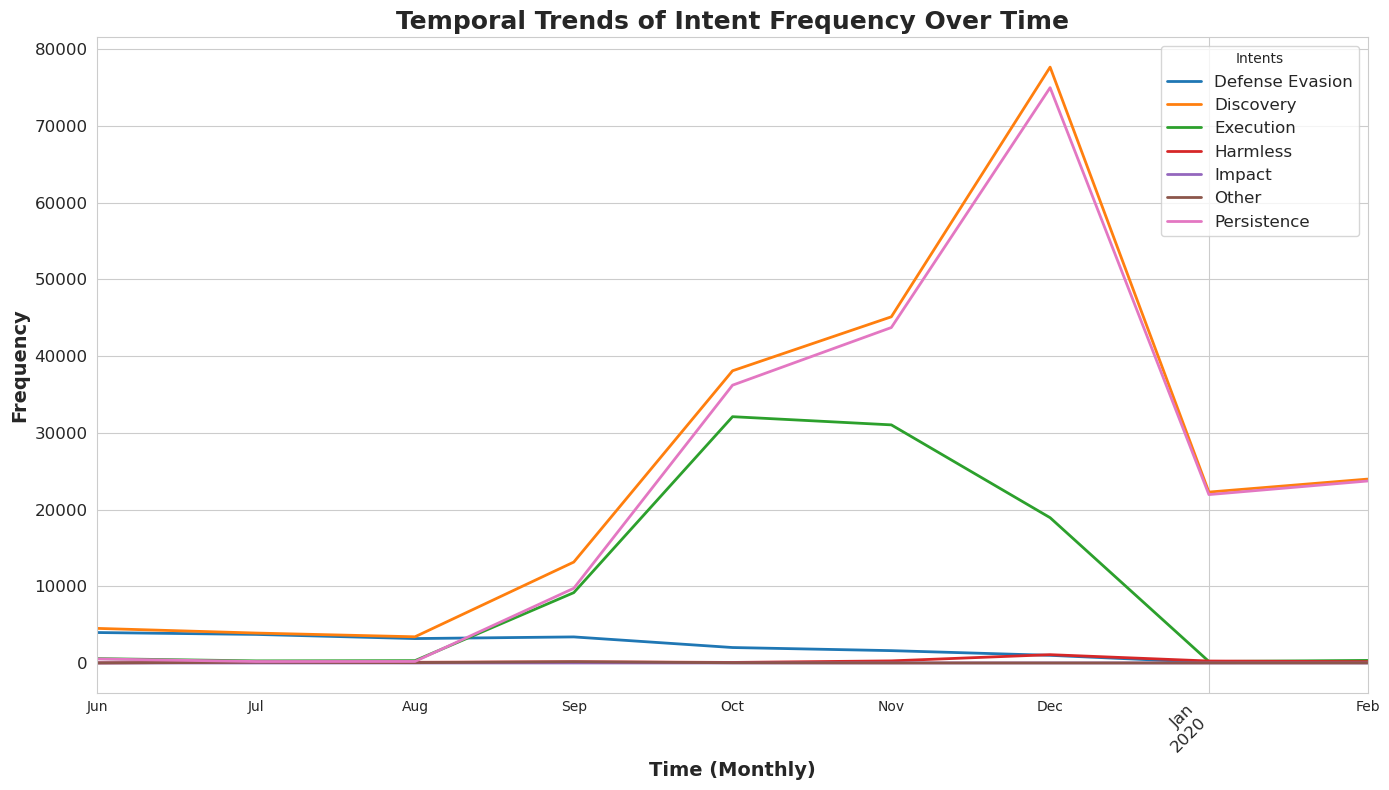

In [17]:
# Analyze temporal trends for intents (e.g., intent frequency over time)
SSH_Attacks['first_timestamp'] = pd.to_datetime(SSH_Attacks['first_timestamp'])  # Ensure timestamp column is in datetime format

# Explode the intents list so each intent has its own row
exploded_data = SSH_Attacks.explode('Set_Fingerprint')

# Group by date and intent to count the occurrences of each intent over time
intent_trends = exploded_data.groupby([exploded_data['first_timestamp'].dt.to_period('M'), 'Set_Fingerprint']).size().reset_index(name='Count')

# Pivot the data to have intents as columns
intent_trends_pivot = intent_trends.pivot(index='first_timestamp', columns='Set_Fingerprint', values='Count').fillna(0)

# Plot the temporal trends for intents
plt.figure(figsize=(14, 8))
intent_trends_pivot.plot(ax=plt.gca(), linewidth=2)
plt.title('Temporal Trends of Intent Frequency Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Time (Monthly)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.legend(title='Intents', fontsize=12)
plt.tight_layout()
plt.show()

# Text Representation

### text

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Example Bag-of-Words
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(SSH_Attacks['full_session'])

# Example TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(SSH_Attacks['full_session'])

# Error Reporting

### text

In [18]:
# Assuming we have a column 'predicted_intent' for demonstration
misclassified = SSH_Attacks[SSH_Attacks['Set_Fingerprint'] != SSH_Attacks['predicted_intent']]
print("Misclassified Sessions:")
print(misclassified[['full_session', 'Set_Fingerprint', 'predicted_intent']].head())

KeyError: 'predicted_intent'